In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel_Regularization'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel_Regularization(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(dataset.X_text.shape[1], 32),
            nn.ReLU(),
            nn.Dropout(.4),
            # nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(.4),
            # nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(.4),
            # nn.BatchNorm1d(26),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel_Regularization().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 5057


In [13]:
# # Do not train if already trained
# if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
#     # Load optimal weights and history
#     model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
#     history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
#     print('Skipping training and loading optimal weights from previous training!')
# else:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=.001, weight_decay=0.0001),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=100,
    patience=100,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1640.09it/s]


Epoch   1/100: RMSE_train: 1,649,576, RMSE_val: 1,372,204


100%|██████████| 646/646 [00:00<00:00, 1814.24it/s]


Epoch   2/100: RMSE_train: 1,095,638, RMSE_val: 1,264,149


100%|██████████| 646/646 [00:00<00:00, 1780.51it/s]


Epoch   3/100: RMSE_train: 989,018, RMSE_val: 1,205,159


100%|██████████| 646/646 [00:00<00:00, 1826.85it/s]


Epoch   4/100: RMSE_train: 968,914, RMSE_val: 1,143,138


100%|██████████| 646/646 [00:00<00:00, 1819.40it/s]


Epoch   5/100: RMSE_train: 943,234, RMSE_val: 1,103,707


100%|██████████| 646/646 [00:00<00:00, 1812.38it/s]


Epoch   6/100: RMSE_train: 922,136, RMSE_val: 1,080,298


100%|██████████| 646/646 [00:00<00:00, 1767.19it/s]


Epoch   7/100: RMSE_train: 922,104, RMSE_val: 1,048,857


100%|██████████| 646/646 [00:00<00:00, 1831.83it/s]


Epoch   8/100: RMSE_train: 917,318, RMSE_val: 1,022,207


100%|██████████| 646/646 [00:00<00:00, 1795.84it/s]


Epoch   9/100: RMSE_train: 909,111, RMSE_val: 997,488


100%|██████████| 646/646 [00:00<00:00, 1853.54it/s]


Epoch  10/100: RMSE_train: 906,804, RMSE_val: 979,722


100%|██████████| 646/646 [00:00<00:00, 1787.24it/s]


Epoch  11/100: RMSE_train: 896,824, RMSE_val: 963,529


100%|██████████| 646/646 [00:00<00:00, 1811.35it/s]


Epoch  12/100: RMSE_train: 902,905, RMSE_val: 950,293


100%|██████████| 646/646 [00:00<00:00, 1808.52it/s]


Epoch  13/100: RMSE_train: 887,693, RMSE_val: 944,121


100%|██████████| 646/646 [00:00<00:00, 1811.94it/s]


Epoch  14/100: RMSE_train: 889,660, RMSE_val: 932,540


100%|██████████| 646/646 [00:00<00:00, 1806.56it/s]


Epoch  15/100: RMSE_train: 888,451, RMSE_val: 926,775


100%|██████████| 646/646 [00:00<00:00, 1748.01it/s]


Epoch  16/100: RMSE_train: 886,455, RMSE_val: 923,352


100%|██████████| 646/646 [00:00<00:00, 1715.53it/s]


Epoch  17/100: RMSE_train: 882,144, RMSE_val: 922,447


100%|██████████| 646/646 [00:00<00:00, 1746.26it/s]


Epoch  18/100: RMSE_train: 880,546, RMSE_val: 917,924


100%|██████████| 646/646 [00:00<00:00, 1797.99it/s]


Epoch  19/100: RMSE_train: 880,703, RMSE_val: 914,208


100%|██████████| 646/646 [00:00<00:00, 1813.81it/s]


Epoch  20/100: RMSE_train: 874,690, RMSE_val: 920,972
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 1736.10it/s]


Epoch  21/100: RMSE_train: 871,256, RMSE_val: 970,916
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 1797.21it/s]


Epoch  22/100: RMSE_train: 870,156, RMSE_val: 915,717
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 1863.86it/s]


Epoch  23/100: RMSE_train: 868,757, RMSE_val: 914,638
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 1845.57it/s]


Epoch  24/100: RMSE_train: 869,465, RMSE_val: 916,849
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 1768.12it/s]


Epoch  25/100: RMSE_train: 870,989, RMSE_val: 914,946
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 1882.01it/s]


Epoch  26/100: RMSE_train: 873,670, RMSE_val: 914,350
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 1823.54it/s]


Epoch  27/100: RMSE_train: 868,680, RMSE_val: 919,213
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 1811.96it/s]


Epoch  28/100: RMSE_train: 861,446, RMSE_val: 914,480
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 1896.37it/s]


Epoch  29/100: RMSE_train: 870,300, RMSE_val: 915,200
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 1854.32it/s]


Epoch  30/100: RMSE_train: 876,805, RMSE_val: 929,826
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 1877.16it/s]


Epoch  31/100: RMSE_train: 865,077, RMSE_val: 915,820
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 1805.30it/s]


Epoch  32/100: RMSE_train: 861,353, RMSE_val: 920,254
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 1871.79it/s]


Epoch  33/100: RMSE_train: 866,209, RMSE_val: 920,570
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 1841.33it/s]


Epoch  34/100: RMSE_train: 862,926, RMSE_val: 916,039
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 1877.51it/s]


Epoch  35/100: RMSE_train: 871,256, RMSE_val: 919,629
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 1748.05it/s]


Epoch  36/100: RMSE_train: 860,663, RMSE_val: 916,805
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 1820.98it/s]


Epoch  37/100: RMSE_train: 853,777, RMSE_val: 921,693
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 1872.82it/s]


Epoch  38/100: RMSE_train: 857,857, RMSE_val: 920,194
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 1840.36it/s]


Epoch  39/100: RMSE_train: 863,450, RMSE_val: 927,973
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 1898.98it/s]


Epoch  40/100: RMSE_train: 851,607, RMSE_val: 921,272
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 1889.77it/s]


Epoch  41/100: RMSE_train: 867,851, RMSE_val: 921,189
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 1899.13it/s]


Epoch  42/100: RMSE_train: 864,331, RMSE_val: 919,043
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 1864.78it/s]


Epoch  43/100: RMSE_train: 864,479, RMSE_val: 922,161
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 1853.29it/s]


Epoch  44/100: RMSE_train: 855,653, RMSE_val: 922,665
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 1842.03it/s]


Epoch  45/100: RMSE_train: 856,282, RMSE_val: 936,672
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 1855.11it/s]


Epoch  46/100: RMSE_train: 850,953, RMSE_val: 925,083
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 1887.55it/s]


Epoch  47/100: RMSE_train: 847,585, RMSE_val: 932,630
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 1872.62it/s]


Epoch  48/100: RMSE_train: 851,356, RMSE_val: 926,429
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 1761.10it/s]


Epoch  49/100: RMSE_train: 856,938, RMSE_val: 927,400
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 1773.49it/s]


Epoch  50/100: RMSE_train: 860,430, RMSE_val: 929,648
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 1810.39it/s]


Epoch  51/100: RMSE_train: 858,305, RMSE_val: 929,078
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 1832.84it/s]


Epoch  52/100: RMSE_train: 856,877, RMSE_val: 929,070
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 1870.77it/s]


Epoch  53/100: RMSE_train: 846,453, RMSE_val: 926,688
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 1782.29it/s]


Epoch  54/100: RMSE_train: 863,495, RMSE_val: 927,268
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 1852.57it/s]


Epoch  55/100: RMSE_train: 858,362, RMSE_val: 932,863
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 1832.23it/s]


Epoch  56/100: RMSE_train: 847,370, RMSE_val: 929,261
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 1845.54it/s]


Epoch  57/100: RMSE_train: 854,561, RMSE_val: 930,421
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 1782.32it/s]


Epoch  58/100: RMSE_train: 848,927, RMSE_val: 934,982
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 1823.20it/s]


Epoch  59/100: RMSE_train: 853,380, RMSE_val: 934,659
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 1830.22it/s]


Epoch  60/100: RMSE_train: 852,476, RMSE_val: 928,912
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:00<00:00, 1839.77it/s]


Epoch  61/100: RMSE_train: 854,392, RMSE_val: 931,662
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:00<00:00, 1852.17it/s]


Epoch  62/100: RMSE_train: 855,269, RMSE_val: 939,998
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:00<00:00, 1784.89it/s]


Epoch  63/100: RMSE_train: 841,615, RMSE_val: 932,769
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:00<00:00, 1851.11it/s]


Epoch  64/100: RMSE_train: 853,804, RMSE_val: 932,547
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:00<00:00, 1843.07it/s]


Epoch  65/100: RMSE_train: 861,276, RMSE_val: 936,725
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:00<00:00, 1840.57it/s]


Epoch  66/100: RMSE_train: 855,258, RMSE_val: 939,776
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:00<00:00, 1819.63it/s]


Epoch  67/100: RMSE_train: 850,822, RMSE_val: 933,316
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:00<00:00, 1884.78it/s]


Epoch  68/100: RMSE_train: 850,276, RMSE_val: 942,047
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:00<00:00, 1848.34it/s]


Epoch  69/100: RMSE_train: 857,974, RMSE_val: 935,544
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:00<00:00, 1814.75it/s]


Epoch  70/100: RMSE_train: 856,369, RMSE_val: 936,346
EarlyStopping counter: 51 out of 100


100%|██████████| 646/646 [00:00<00:00, 1827.92it/s]


Epoch  71/100: RMSE_train: 847,727, RMSE_val: 934,541
EarlyStopping counter: 52 out of 100


100%|██████████| 646/646 [00:00<00:00, 1833.76it/s]


Epoch  72/100: RMSE_train: 843,766, RMSE_val: 937,545
EarlyStopping counter: 53 out of 100


100%|██████████| 646/646 [00:00<00:00, 1853.01it/s]


Epoch  73/100: RMSE_train: 843,545, RMSE_val: 935,806
EarlyStopping counter: 54 out of 100


100%|██████████| 646/646 [00:00<00:00, 1839.02it/s]


Epoch  74/100: RMSE_train: 854,975, RMSE_val: 934,886
EarlyStopping counter: 55 out of 100


100%|██████████| 646/646 [00:00<00:00, 1698.99it/s]


Epoch  75/100: RMSE_train: 849,143, RMSE_val: 936,158
EarlyStopping counter: 56 out of 100


100%|██████████| 646/646 [00:00<00:00, 1863.46it/s]


Epoch  76/100: RMSE_train: 851,748, RMSE_val: 936,731
EarlyStopping counter: 57 out of 100


100%|██████████| 646/646 [00:00<00:00, 1838.84it/s]


Epoch  77/100: RMSE_train: 853,748, RMSE_val: 940,826
EarlyStopping counter: 58 out of 100


100%|██████████| 646/646 [00:00<00:00, 1846.96it/s]


Epoch  78/100: RMSE_train: 852,996, RMSE_val: 948,343
EarlyStopping counter: 59 out of 100


100%|██████████| 646/646 [00:00<00:00, 1881.06it/s]


Epoch  79/100: RMSE_train: 848,280, RMSE_val: 940,257
EarlyStopping counter: 60 out of 100


100%|██████████| 646/646 [00:00<00:00, 1840.68it/s]


Epoch  80/100: RMSE_train: 854,647, RMSE_val: 940,729
EarlyStopping counter: 61 out of 100


100%|██████████| 646/646 [00:00<00:00, 1832.82it/s]


Epoch  81/100: RMSE_train: 847,727, RMSE_val: 937,020
EarlyStopping counter: 62 out of 100


100%|██████████| 646/646 [00:00<00:00, 1858.46it/s]


Epoch  82/100: RMSE_train: 861,175, RMSE_val: 939,379
EarlyStopping counter: 63 out of 100


100%|██████████| 646/646 [00:00<00:00, 1872.17it/s]


Epoch  83/100: RMSE_train: 843,589, RMSE_val: 947,300
EarlyStopping counter: 64 out of 100


100%|██████████| 646/646 [00:00<00:00, 1871.09it/s]


Epoch  84/100: RMSE_train: 842,319, RMSE_val: 946,792
EarlyStopping counter: 65 out of 100


100%|██████████| 646/646 [00:00<00:00, 1903.99it/s]


Epoch  85/100: RMSE_train: 849,433, RMSE_val: 944,222
EarlyStopping counter: 66 out of 100


100%|██████████| 646/646 [00:00<00:00, 1899.69it/s]


Epoch  86/100: RMSE_train: 846,714, RMSE_val: 951,187
EarlyStopping counter: 67 out of 100


100%|██████████| 646/646 [00:00<00:00, 1890.95it/s]


Epoch  87/100: RMSE_train: 856,362, RMSE_val: 941,000
EarlyStopping counter: 68 out of 100


100%|██████████| 646/646 [00:00<00:00, 1884.51it/s]


Epoch  88/100: RMSE_train: 844,180, RMSE_val: 942,465
EarlyStopping counter: 69 out of 100


100%|██████████| 646/646 [00:00<00:00, 1887.07it/s]


Epoch  89/100: RMSE_train: 851,127, RMSE_val: 944,737
EarlyStopping counter: 70 out of 100


100%|██████████| 646/646 [00:00<00:00, 1777.69it/s]


Epoch  90/100: RMSE_train: 847,301, RMSE_val: 940,988
EarlyStopping counter: 71 out of 100


100%|██████████| 646/646 [00:00<00:00, 1888.84it/s]


Epoch  91/100: RMSE_train: 852,102, RMSE_val: 1,073,481
EarlyStopping counter: 72 out of 100


100%|██████████| 646/646 [00:00<00:00, 1902.38it/s]


Epoch  92/100: RMSE_train: 844,556, RMSE_val: 948,927
EarlyStopping counter: 73 out of 100


100%|██████████| 646/646 [00:00<00:00, 1913.85it/s]


Epoch  93/100: RMSE_train: 845,818, RMSE_val: 947,377
EarlyStopping counter: 74 out of 100


100%|██████████| 646/646 [00:00<00:00, 1922.94it/s]


Epoch  94/100: RMSE_train: 847,657, RMSE_val: 944,814
EarlyStopping counter: 75 out of 100


100%|██████████| 646/646 [00:00<00:00, 1928.78it/s]


Epoch  95/100: RMSE_train: 847,459, RMSE_val: 956,629
EarlyStopping counter: 76 out of 100


100%|██████████| 646/646 [00:00<00:00, 1896.05it/s]


Epoch  96/100: RMSE_train: 851,999, RMSE_val: 947,882
EarlyStopping counter: 77 out of 100


100%|██████████| 646/646 [00:00<00:00, 1908.02it/s]


Epoch  97/100: RMSE_train: 843,114, RMSE_val: 944,406
EarlyStopping counter: 78 out of 100


100%|██████████| 646/646 [00:00<00:00, 1888.73it/s]


Epoch  98/100: RMSE_train: 845,553, RMSE_val: 948,627
EarlyStopping counter: 79 out of 100


100%|██████████| 646/646 [00:00<00:00, 1901.54it/s]


Epoch  99/100: RMSE_train: 844,059, RMSE_val: 950,157
EarlyStopping counter: 80 out of 100


100%|██████████| 646/646 [00:00<00:00, 1793.72it/s]

Epoch 100/100: RMSE_train: 836,901, RMSE_val: 947,057
EarlyStopping counter: 81 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   777490.891  444959.509  0.583  0.612
val     916377.294  506673.944  0.654  0.452
test    927200.766  511257.444  0.629  0.445
--------------------------------------------
total   824048.659  464389.688  0.599  0.563


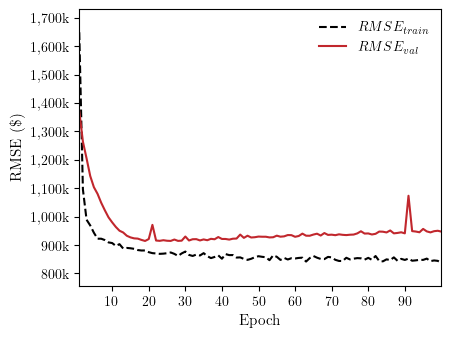

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

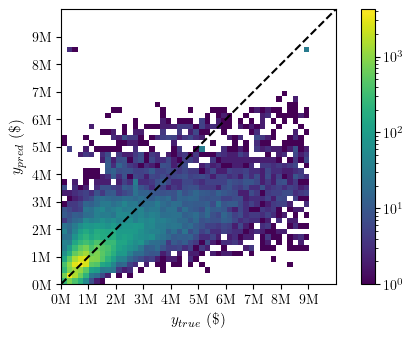

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')